In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [69]:
df = pd.read_csv('cars_data.csv', encoding='latin1')

In [70]:
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm


# Data Cleaning Steps
1. Rename columns to include metrics
2. Clean numeric values and handle ranges
3. Standardize horsepower notation
4. Remove rows with N/A and missing values

In [71]:
# Define a helper function to clean string, handle ranges, and convert to numeric
def clean_and_average(value_str):
    """
    Cleans a string value, removes specified units,
    and calculates the average if it's a range.
    """
    if pd.isna(value_str):
        return np.nan
    
    # Convert to string, lowercase, and strip common units/chars
    clean_str = str(value_str).lower()
    clean_str = (clean_str.replace('hp', '')
                            .replace('nm', '')
                            .replace('sec', '')
                            .replace('km/h', '')
                            .replace('$', '')
                            .replace(',', '')
                            .replace('cc', '')
                            .strip())
    
    # Check for range (e.g., "70-85" or "100 - 140")
    if '-' in clean_str:
        try:
            parts = clean_str.split('-')
            # Ensure parts are stripped of any remaining whitespace
            low = float(parts[0].strip())
            high = float(parts[1].strip())
            return (low + high) / 2
        except (ValueError, IndexError, TypeError):
            # Failed to parse the range
            return np.nan
    else:
        # Not a range, just convert to float
        try:
            return float(clean_str)
        except ValueError:
            # Failed to convert
            return np.nan

In [72]:
if not df.empty:
    # 1. Replace 'N/A' strings with numpy.nan
    df.replace('N/A', np.nan, inplace=True)

    # 2. Apply the cleaning function to the relevant columns
    df['CC/Battery Capacity'] = df['CC/Battery Capacity'].apply(clean_and_average)
    df['HorsePower'] = df['HorsePower'].apply(clean_and_average)
    df['Total Speed'] = df['Total Speed'].apply(clean_and_average)
    df['Performance(0 - 100 )KM/H'] = df['Performance(0 - 100 )KM/H'].apply(clean_and_average)
    df['Cars Prices'] = df['Cars Prices'].apply(clean_and_average)
    df['Torque'] = df['Torque'].apply(clean_and_average)

    # 3. Convert 'Seats' column, coercing errors to NaN
    df['Seats'] = pd.to_numeric(df['Seats'], errors='coerce')

    # 4. Rename columns to include metrics
    df.rename(columns={
        'CC/Battery Capacity': 'Capacity (cc)',
        'HorsePower': 'HorsePower (hp)',
        'Total Speed': 'Total Speed (km/h)',
        'Performance(0 - 100 )KM/H': 'Performance 0-100 (sec)',
        'Cars Prices': 'Price ($)',
        'Torque': 'Torque (Nm)'
    }, inplace=True)

In [73]:
df.dropna(inplace=True)

In [74]:
df.head(30)

,Company Names,Cars Names,Engines,Capacity (cc),HorsePower (hp),Total Speed (km/h),Performance 0-100 (sec),Price ($),Fuel Types,Seats,Torque (Nm)
0,FERRARI,SF90 STRADALE,V8,3990.0,963.0,340.0,2.5,1100000.0,plug in hyrbrid,2.0,800.0
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563.0,250.0,5.3,460000.0,Petrol,5.0,900.0
2,Ford,KA+,1.2L Petrol,1200.0,77.5,165.0,10.5,13500.0,Petrol,5.0,120.0
3,MERCEDES,GT 63 S,V8,3982.0,630.0,250.0,3.2,161000.0,Petrol,4.0,900.0
4,AUDI,AUDI R8 Gt,V10,5204.0,602.0,320.0,3.6,253290.0,Petrol,2.0,560.0
5,BMW,Mclaren 720s,V8,3994.0,710.0,341.0,2.9,499000.0,Petrol,2.0,770.0
6,ASTON MARTIN,VANTAGE F1,V8,3982.0,656.0,314.0,3.6,193440.0,Petrol,2.0,685.0
7,BENTLEY,Continental GT Azure,V8,3996.0,550.0,318.0,4.0,311000.0,Petrol,4.0,900.0
8,LAMBORGHINI,VENENO ROADSTER,V12,6498.0,750.0,356.0,2.9,4500000.0,Petrol,2.0,690.0
9,FERRARI,F8 TRIBUTO,V8,3900.0,710.0,340.0,2.9,280000.0,Petrol,2.0,770.0


Text(0, 0.5, 'Company')

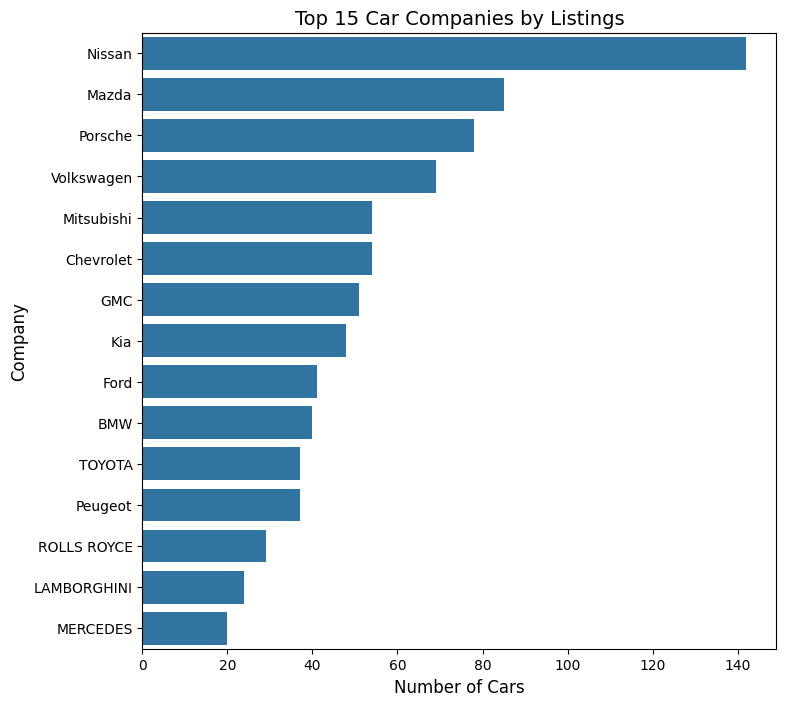

In [75]:
plt.figure(figsize=(18, 8))
# Subplot A: Top 15 Most Common Car Companies
plt.subplot(1, 2, 1)
top_15_companies = df['Company Names'].value_counts().nlargest(15)
sns.barplot(x=top_15_companies.values, y=top_15_companies.index)
plt.title('Top 15 Car Companies by Listings', fontsize=14)
plt.xlabel('Number of Cars', fontsize=12)
plt.ylabel('Company', fontsize=12)

Generating Plot 3: Horsepower Relationship Plots...


Text(0, 0.5, 'Price ($) (Log Scale)')

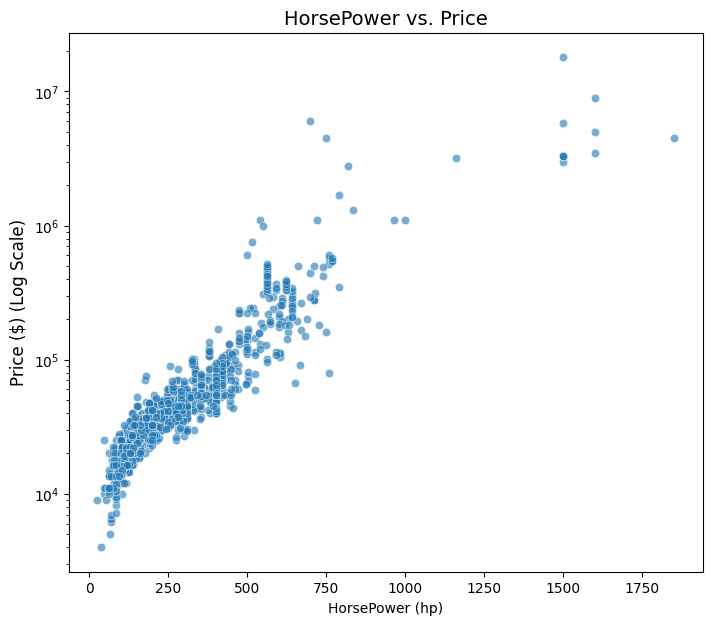

In [76]:
print("Generating Plot 3: Horsepower Relationship Plots...")
plt.figure(figsize=(18, 7))
# Subplot A: Horsepower vs. Price
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='HorsePower (hp)', y='Price ($)', alpha=0.6)
plt.yscale('log') # Use log scale again for the wide price range
plt.title('HorsePower vs. Price', fontsize=14)
plt.ylabel('Price ($) (Log Scale)', fontsize=12)


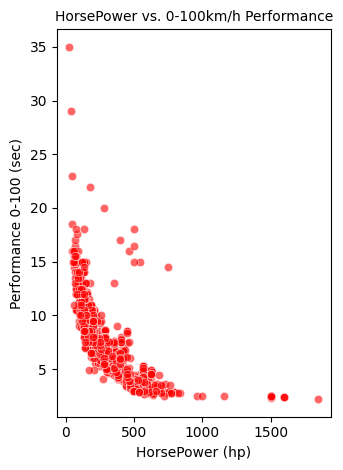

In [77]:
plt.subplot(1,2,2)
sns.scatterplot(data=df, x='HorsePower (hp)', y='Performance 0-100 (sec)', alpha=0.6, color='r')
plt.title('HorsePower vs. 0-100km/h Performance', fontsize=10)

plt.tight_layout()
plt.savefig('3_horsepower_relationships.png')
plt.show() # <-- ADDED: This will now display the plot on your screen.
plt.close()

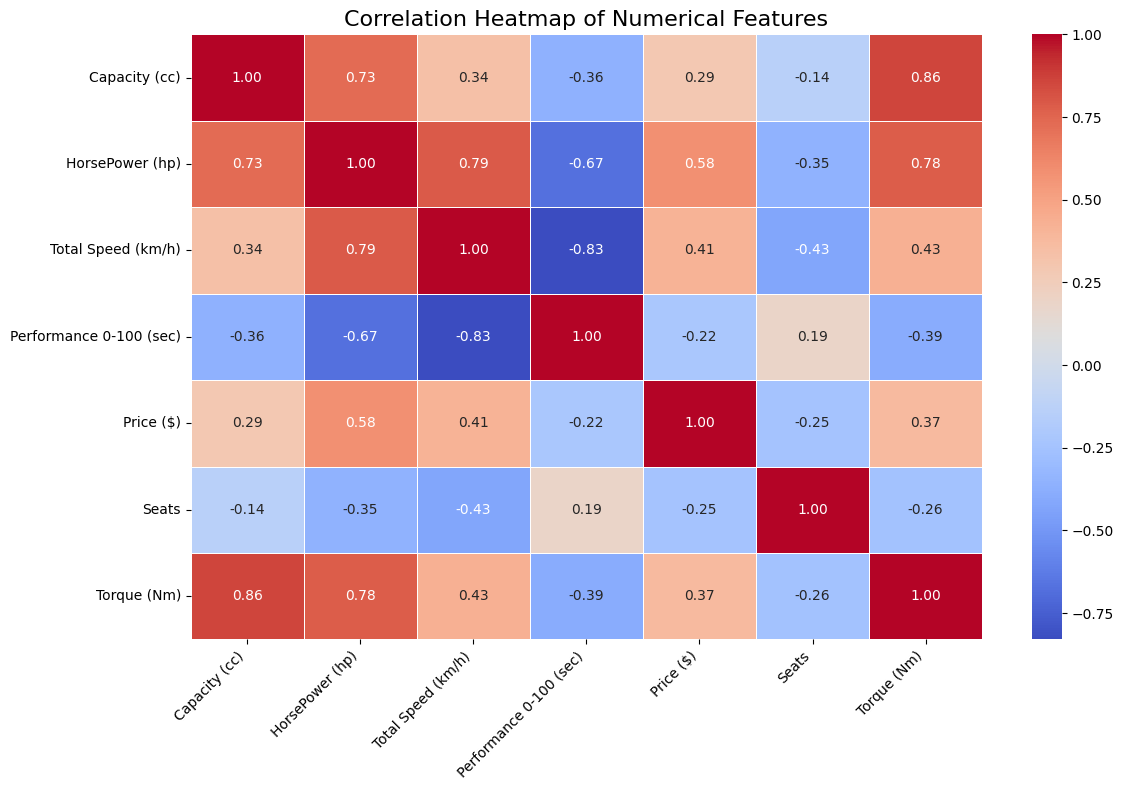

In [78]:
numerical_df = df.select_dtypes(include=np.number)
corr_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('4_correlation_heatmap.png')
plt.show() # <-- ADDED: This will now display the plot on your screen.
plt.close()


In [79]:
print("\n--- Preparing Data for Modeling ---")
features = [
    'HorsePower (hp)', 'Total Speed (km/h)', 'Performance 0-100 (sec)',
    'Capacity (cc)', 'Seats'
]
target = 'Price ($)'

X = df[features]
y = df[target]

print(f"Features (X): {X.columns.tolist()}")
print(f"Target (y): {target}")


--- Preparing Data for Modeling ---
Features (X): ['HorsePower (hp)', 'Total Speed (km/h)', 'Performance 0-100 (sec)', 'Capacity (cc)', 'Seats']
Target (y): Price ($)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
print("\n--- Training Model 1: Linear Regression ---")
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

print("Linear Regression Performance:")
print(f"  R-squared: {r2_score(y_test, y_pred_lin):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test, y_pred_lin):,.2f}")


--- Training Model 1: Linear Regression ---
Linear Regression Performance:
  R-squared: 0.6445
  Mean Squared Error: 186,022,482,775.96


In [84]:
print("\n--- Training Model 2: Ridge Regression ---")
ridge_reg = Ridge(random_state=42)
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

print("Ridge Regression Performance:")
print(f"  R-squared: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test, y_pred_ridge):,.2f}")


--- Training Model 2: Ridge Regression ---
Ridge Regression Performance:
  R-squared: 0.6434
  Mean Squared Error: 186,572,154,721.59
